# Валидация данных. Методы валидации

Перед тем как приступить к изучению валидации данных, давайте постараемся ответить на следующий вопрос: **«Почему нельзя обучать модель на всех доступных данных?»**

> Основная цель обучения модели — получить модель с хорошей прогностической способностью, которая решает поставленную задачу с заданным показателем метрики. 

Нам не столько важен результат предсказания на том наборе данных, на котором мы обучаем модель (нам уже известны все значения признаков в нём), сколько важно уметь предсказывать значения целевого признака для объектов, которых мы ещё не видели.

> Таким образом, главная цель машинного обучения — усвоить общие закономерности в данных, а не просто запомнить **обучающий, или тренировочный, набор данных (training data).**

> Поэтому так важно иметь отложенный набор данных (с известными правильными ответами), который модель не видела во время обучения. На нём мы будем оценивать качество обученной модели.

В предыдущих модулях по машинному обучению тот набор данных, на котором мы проверяли качество построенной модели, мы называли **тестовым набором данных (testing data).** Мы заранее выделяли этот набор данных для того, чтобы рассчитать финальную метрику модели и сделать вывод о том, устраивает ли нас качество моделирования. Такой подход называется **двухкомпонентным.**

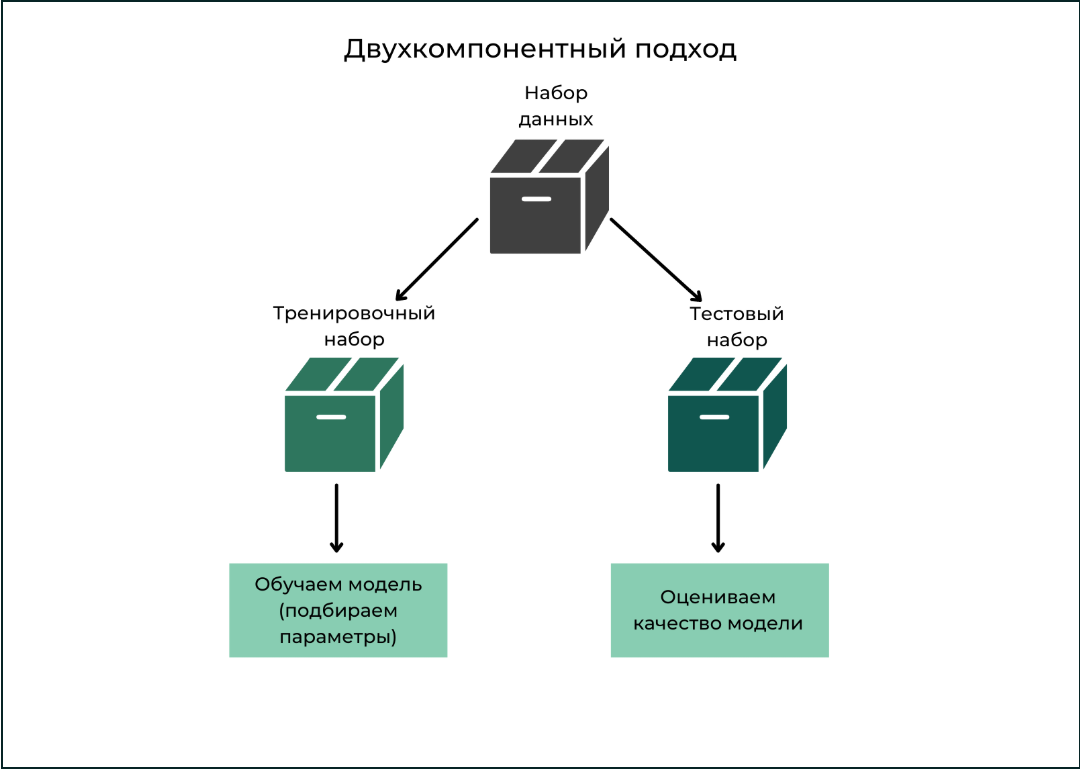

> **Примечание.** Ранее мы использовали тестовый набор не только для проверки итогового качества, но и для подбора внешних параметров. Вспомните: мы выбирали оптимальные пороги вероятности и коэффициенты регуляризации, при которых наблюдался максимум целевой метрики ***(мы использовали F1-меру).*** 

> Однако такой подход не совсем корректен, ведь мы подстраивали модель под тестовую выборку, то есть по сути занимались небольшим самообманом. Тестовая выборка должна быть «независимым судьёй», который должен объективно и непредвзято «выносить приговор» нашей модели.

Из-за этого в больших Data Science-проектах используется не два, а три набора данных: в дополнение к тренировочному и тестовому набору данных выделяется **валидационный набор (validation data).** Этот набор используется для промежуточного контроля качества модели и настройки внешних параметров, которые задаёт исследователь при построении модели. Такой подход называется **трёхкомпонентным.**

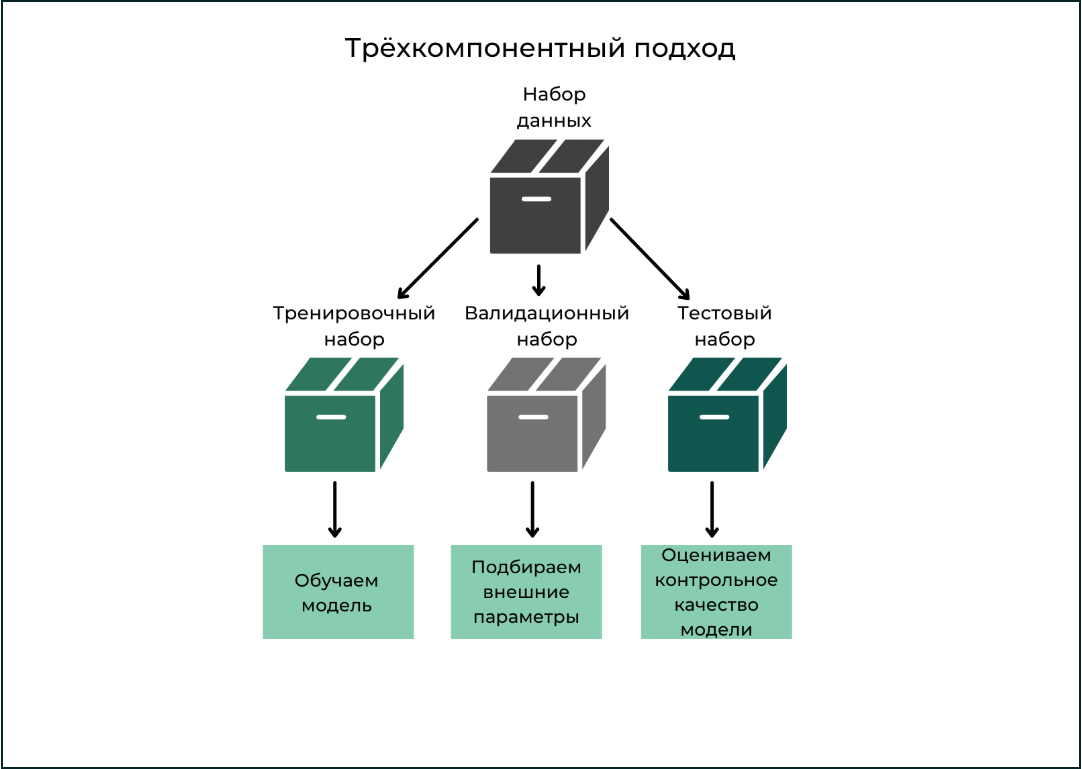

Итак, существует три основных вида выборок, которые используются в машинном обучении:

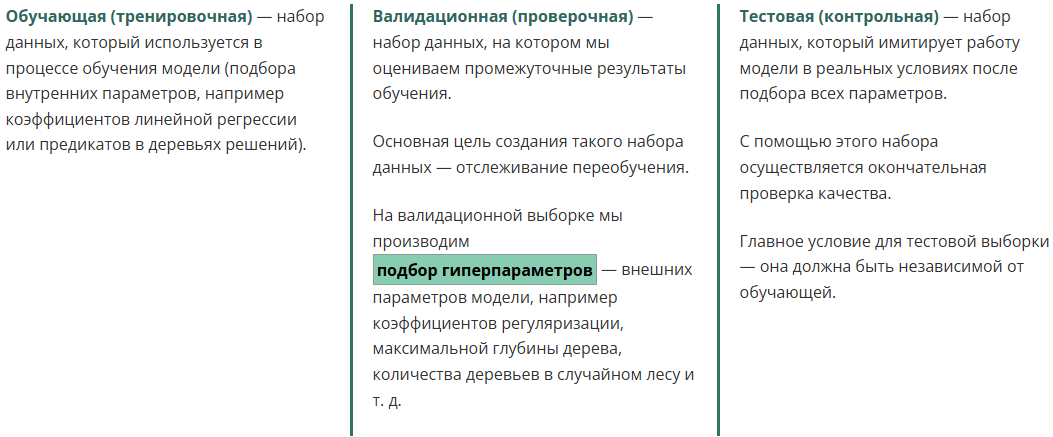

Подробнее о типах наборов данных и их предназначениях советуем прочитать [здесь.](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)

**Особенности терминологии**

> В промышленности, научных кругах и различной литературе термины валидационная и тестовая выборка зачастую употребляются как синонимы. Строго говоря, они не являются таковыми.

> Тестирование — это попытка что-то выяснить, а валидация — доказать, что что-то является истиной (в нашем случае — доказать, что качество модели на валидационной выборке совпадает с качеством при обучении).

> Вне зависимости от того, как будут называться контрольные выборки, важная концепция, которую необходимо сохранить, состоит в том, что **окончательный набор** (называемый тестом или валидацией) не используется в процессе обучения модели, а **используется исключительно для оценки её качества.**


> Процесс проверки предсказательной способности модели машинного обучения называется **валидацией.**

Существует несколько методов такого контроля. Мы последовательно рассмотрим каждый из них.

Но прежде чем мы перейдём к обсуждению методов валидации, давайте познакомимся с данными, на которых будем практиковаться ↓

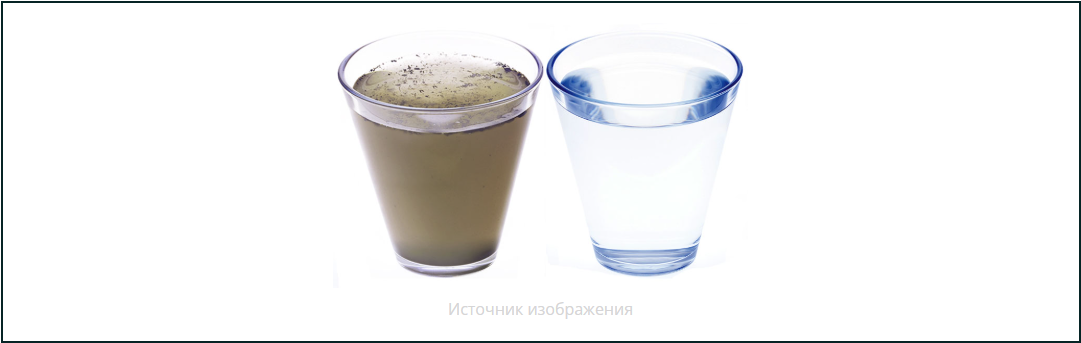

В этом модуле мы будем решать **задачу классификации:** классифицировать воду на пригодную  и не пригодную для питья на основе её химического состава.

Скачать набор данных можно здесь. С подробным описанием датасета и столбцов таблицы ознакомьтесь в [источнике.](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
 
from sklearn import metrics #метрики
from sklearn import model_selection #методы разделения и валидации
from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

Прочитаем данные о собранных образцах воды и выведем первые пять строк таблицы:

In [3]:
water_data = pd.read_csv('data/water_potability.csv')
water_data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Невооруженным глазом видно, что большинство столбцов таблицы являются числовыми. Целевой признак — **Potability** (пригодность для питья): 1 — вода пригодна, 0 — вода не пригодна.

В данных есть пропуски. Выведем информацию о них в процентном соотношении:

In [4]:
display(water_data.isnull().mean() * 100)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Итак, у нас отсутствует около 15 % информации о кислотности воды (*ph*), около 24 % — о содержании сульфатов (*Sulfate*) и около 5 % — о тригалометанах (*Trihalomethanes*). Мы знаем, что пропуски — непосильная ноша для большинства моделей машинного обучения. Их необходимо обработать.

Заполним пропуски медианным значением в признаке зависимости класса воды (*Potability*). Для этого сгруппируем данные по признаку *Potability*, посчитаем медиану в каждой группе, а затем отправим результат в метод fillna():

In [5]:
#Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(water_data.groupby('Potability')['ph'].transform('median'))
water_data['Sulfate'] = water_data['Sulfate'].fillna(water_data.groupby('Potability')['Sulfate'].transform('median'))
water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

Убедимся в отсутствии пропусков:

In [6]:
display(water_data.isnull().mean() * 100)

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

Теперь проблема пропусков устранена. Давайте по традиции разделим набор данных на матрицу наблюдений X и вектор правильных ответов y:

In [7]:
X = water_data.drop('Potability', axis=1)
y = water_data['Potability']

### Задание 2.1

Зачем нужно разделение на валидационную и тестовую выборки?

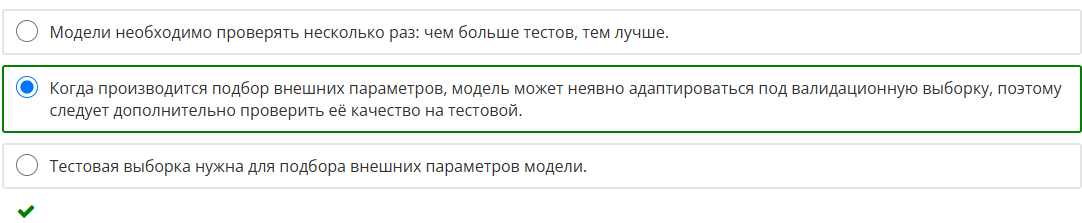

### Задание 2.2

Когда выборка делится на несколько частей, какая часть обычно самая большая?

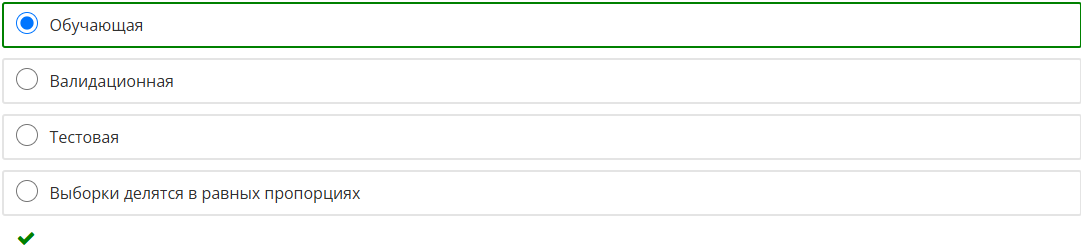

## HOLD-OUT

> Метод **hold-out (отложенная выборка)** нам уже знаком. Это самый простой и очень популярный метод.

> Его идея состоит в том, что для проверки модели мы просто случайным образом разбиваем весь набор данных на обучающую, валидационную и тестовую выборки (последняя — по желанию).

Обычно разбиение производится в соотношении 70/30 или 80/20 при двухкомпонентном подходе, и в соотношении 70/15/15 или 80/10/10 — при трёхкомпонентном.

Схема разбиения представлена ниже:

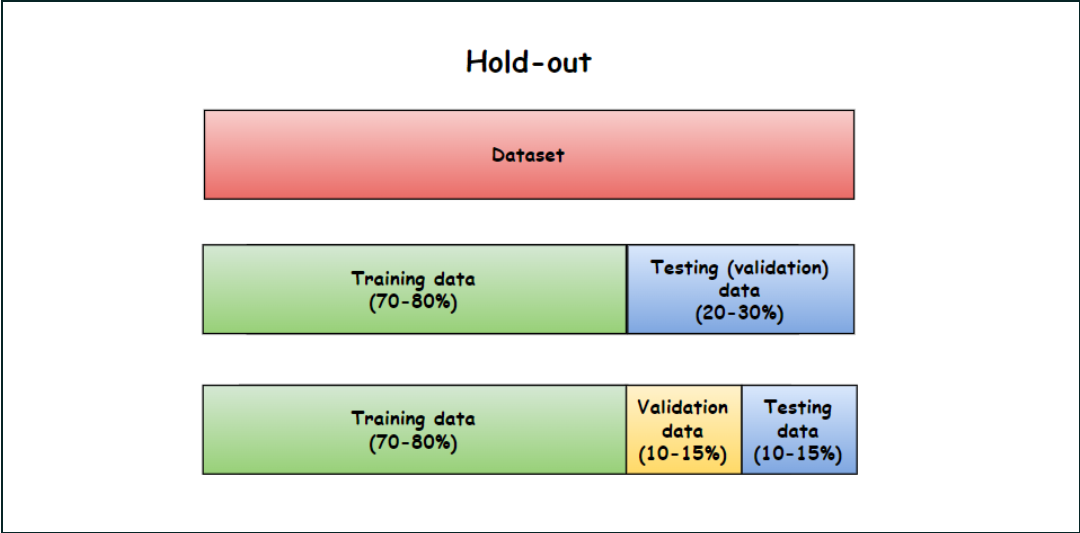

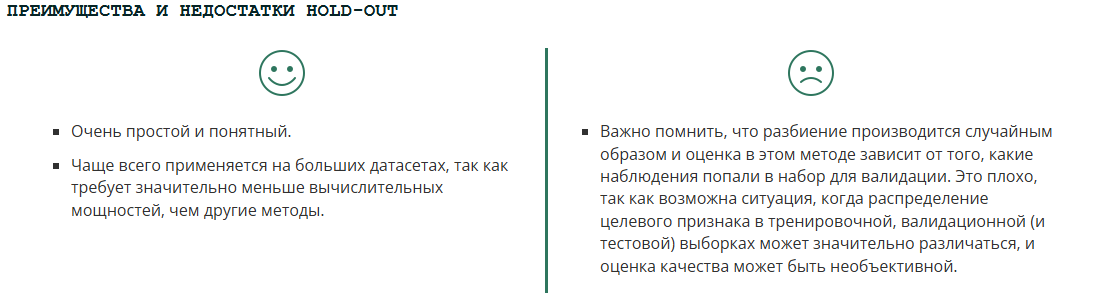

### Реализация метода в sklearn

Все методы разбиения выборки и валидации, которые мы будем изучать, находятся в модуле model_selection, мы импортировали его заранее.

Метод hold-out реализован в уже знакомой вам функции train_test_split(). Она предназначена для разбиения исходного набора данных случайным образом на две части в заданных соотношениях.

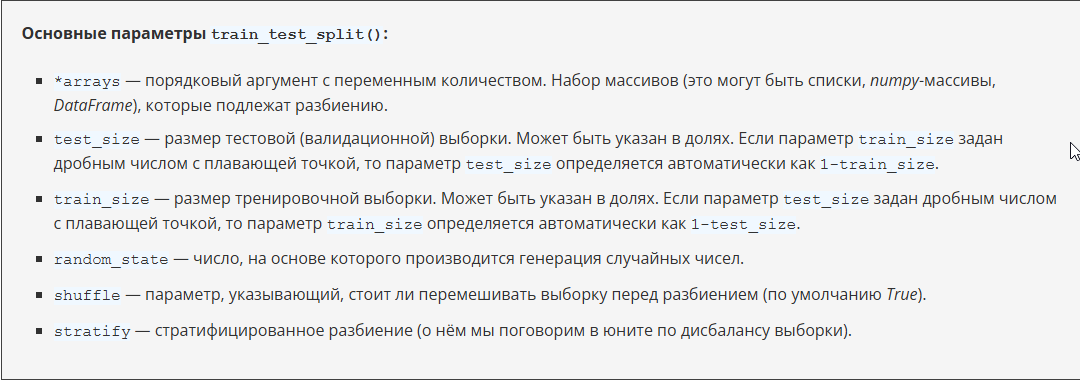

Если мы используем **двухкомпонентный подход** (разбиваем выборку на тренировочную и валидационную, она же тестовая), то всё очень просто: нам лишь нужно вызвать функцию train_test_split() и передать в неё матрицу наблюдений X и вектор-столбец с правильными ответами y.

Для примера разделим выборку в соотношении 80/20 (test_size=0.2), в качестве значения параметра random_state по традиции возьмём число 42.

Функция вернёт четыре массива:

- таблицу X с обучающими примерами,
- таблицу X с примерами для валидации,
- столбец y с ответами на обучающие примеры,
- столбец y с ответами на валидационные примеры.

In [8]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

Проверим размеры полученных выборок:

In [9]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
  
## Train shape: (2620, 9)
## Valid shape: (656, 9)

Train shape: (2620, 9)
Valid shape: (656, 9)


Итак, 2620 образцов воды являются обучающими — в них модель будет искать закономерности и подбирать внутренние параметры, а 656 являются валидационными — на них мы будем производить контроль качества.

Далее нам останется только обучить модель на тренировочной выборке (X_train, y_train) и рассчитать метрики на валидационной выборке (X_valid, y_valid).

В качестве модели будем использовать **дерево решений** с максимальной глубиной 7, энтропией в качестве критерия информативности, минимальное число объектов в листе дерева — 5.

После обучения сделаем предсказание для каждой из выборок и рассчитаем метрику. В качестве метрики для простоты возьмём долю правильных ответов — *accuracy.*

In [10]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
#Обучаем модель на тренировочной выборке
model.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
#Выводим значения метрик
print('Train hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Valid hold-out accuracy: {:.2f}'.format(metrics.accuracy_score(y_valid, y_valid_pred))) 
 
# Train hold-out accuracy: 0.82
# Valid hold-out accuracy: 0.77

Train hold-out accuracy: 0.82
Valid hold-out accuracy: 0.77


Если же мы используем **трёхкомпонентный подход** (разбиваем выборку на тренировочную, валидационную и отдельную тестовую), нам понадобится чуть больше кода. К сожалению, в *sklearn* нет специализированного функционала для такого разбиения.

Применим функцию train_test_split() дважды: сначала разобьём исходный набор на тренировочный и валидационный в соотношении 80/20, затем разобьём валидационный набор на валидационный и тестовый в соотношении 50/50. В итоге наша выборка будет разбита в соотношении 80/10/10:

In [11]:
#разбиваем исходную выборку на тренировочную и валидационную в соотношении 80/20
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
#разбиваем валидационную выборку на валидационную и тестовую в соотношении 50/50
X_valid, X_test, y_valid, y_test = model_selection.train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

Выводим размерности:

In [12]:
print('Train shape: {}'.format(X_train.shape))
print('Valid shape: {}'.format(X_valid.shape))
print('Test shape: {}'.format(X_test.shape))

## Train shape: (2620, 9)
## Valid shape: (328, 9)
## Test shape: (328, 9)

Train shape: (2620, 9)
Valid shape: (328, 9)
Test shape: (328, 9)


В этом случае мы будем обучаться на 2620 примерах, 328 будем использовать для промежуточного контроля и подбора внешних параметров и ещё 328 будут нашим контрольным рубежом — их мы будем использовать для принятия финального решения о качестве модели.

### Задание 2.3

Какая потенциальная проблема может возникнуть, если использовать для валидации метод hold-out?

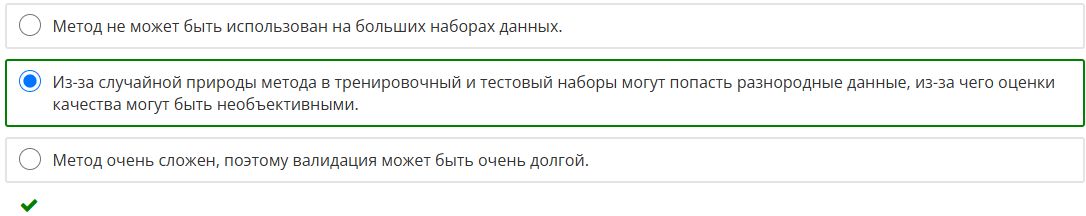

### Задание 2.4

С помощью какой функции в sklearn создаётся отложенная выборка?

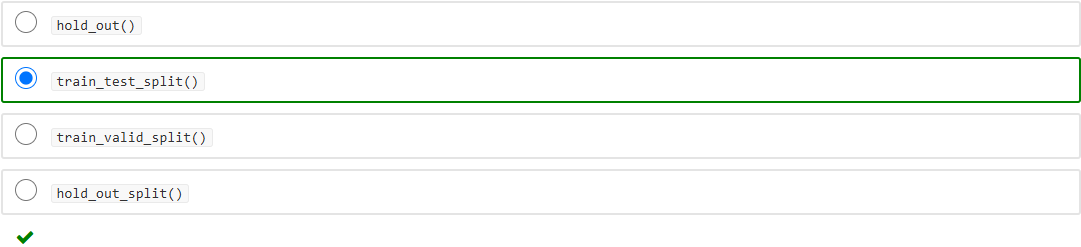

## K-FOLD

> Метод k-fold более известен как **кросс-валидация (cross validation)**, или **перекрёстный контроль.**

Пожалуй, это самый популярный метод валидации для оценки качества моделирования, и он используется практически во всех проектах. Эта идея также применяется во многих моделях и методах машинного обучения, например в стекинге.

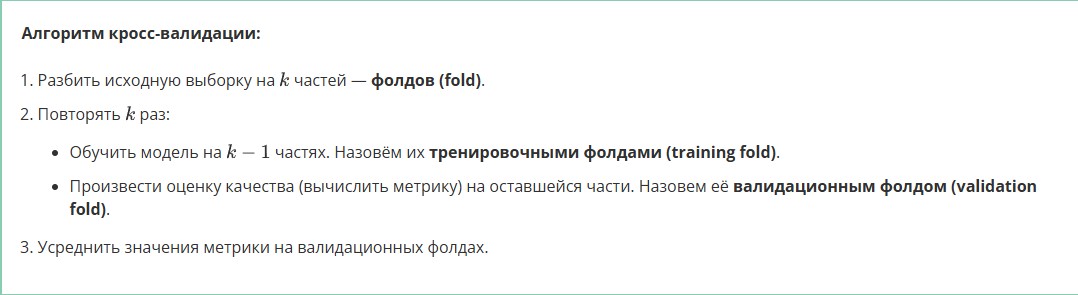

На рисунке ниже представлена схема работы кросс-валидации с предварительно выделенной для тестирования выборкой, то есть первоначально весь датасет разделяется на тренировочную и тестовую (отложенную) выборки. Тестовые данные (*testing data*) используются только для финального контроля качества и сравнения моделей между собой. Тренировочные данные (*training data*) используются для кросс-валидации, разделяясь при каждой итерации на тренировочные и валидационные фолды (*training fold и validation fold*):

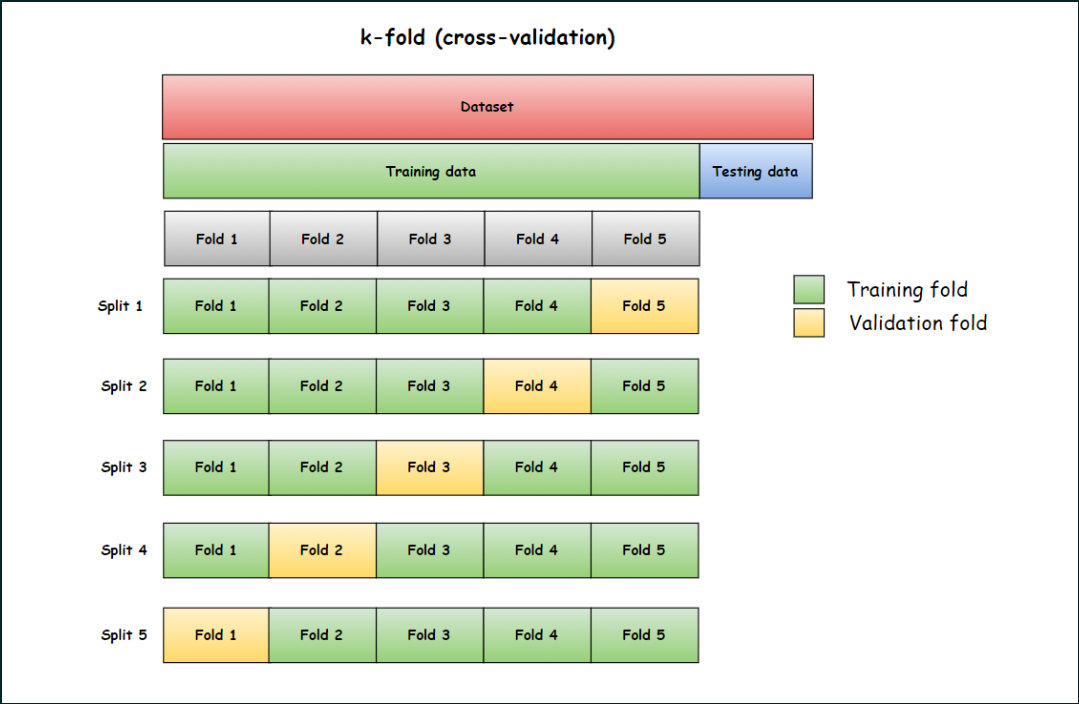

Благодаря такому подходу мы избавляемся от необходимости создавать отложенную валидационную выборку — мы генерируем её искусственно на каждом из этапов кросс-валидации из исходного набора данных. Каждая из  частей исходного обучающего набора данных используется в качестве валидационной выборки.

Для больших наборов данных в качестве значения ***k*** часто берут 10, то есть выборка разбивается на десять фолдов. В случае маленьких выборок ***k*** берут равным 3 или 5.

>  Чем больше ***k***, тем больше моделей будут обучаться, тем объективнее будет оценка качества, однако тем больше времени займёт процесс валидации.

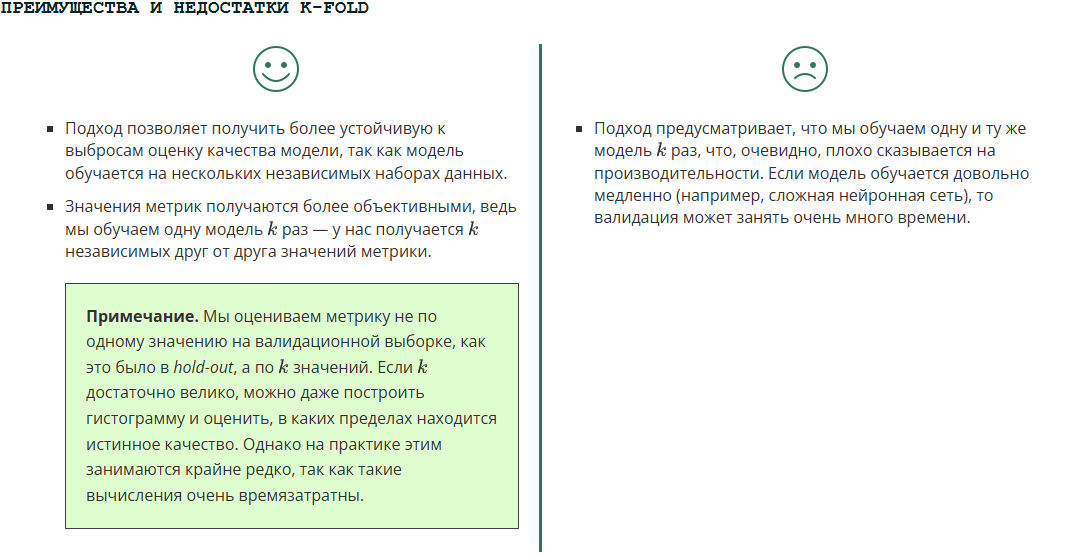

### Реализация метода в sklearn

В библиотеке sklearn метод k-fold реализован в классе [KFold.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

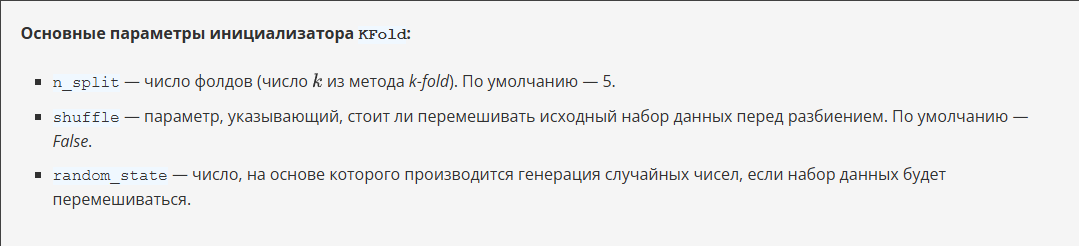

У объекта класса *KFold* есть метод split(). В данный метод необходимо передать матрицу наблюдений X и вектор-столбец ответов y — метод вернёт генератор, который позволит получать индексы тренировочной и валидационной выборок, сгенерированных по методу k-fold.

Будем использовать двухкомпонентный контроль, то есть подавать в кросс-валидацию весь доступный набор данных без предварительного выделения тестовой выборки.

Создадим объект *KFold* для кросс-валидации с пятью фолдами, остальные параметры оставим по умолчанию. Затем организуем цикл for для получения элементов из генератора, созданного с помощью метода split(). На каждой итерации в переменных train_index и valid_index будут находиться индексы текущей тренировочной и валидационной выборок соответственно.

В цикле будем:

- выделять строки таблицы, относящиеся к текущим тренировочной и валидационной выборкам, в отдельные таблицы;
- обучать дерево решений;
- делать предсказания для текущих тренировочной и валидационной выборок;
- рассчитывать метрику accuracy на текущих выборках и заносить её значение в список.

Код будет выглядеть следующим образом:

In [15]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
#Создаём список для хранения тренировочных и валидационных метрик
train_metrics = []
val_metrics = []
#Организуем цикл для кросс-валидации (используем весь набор данных)
#train_index — индексы тренировочной выборки
#valid_index — индексы валидационной выборки
for train_index, valid_index in kf.split(X, y): 
    #Создаём тренировочную и валидационную выборку, обращаясь по текущим индексам
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]
    #Обучаем дерево решений на тренировочной выборке
    model.fit(X_train, y_train)
    #Делаем предсказание для каждой из выборок
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    #Рассчитываем метрику и заносим её в список
    train_metrics.append(metrics.accuracy_score(y_train, y_train_pred))
    val_metrics.append(metrics.accuracy_score(y_valid, y_valid_pred))

Выведем содержимое массивов train_metrics и val_metrics:

In [16]:
print(train_metrics)
print(val_metrics)
 
## [0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
## [0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]

[0.8034351145038168, 0.8168637924456315, 0.8027470431133156, 0.8267836703548264, 0.8157191911484166]
[0.7957317073170732, 0.7053435114503817, 0.7358778625954199, 0.7282442748091603, 0.732824427480916]


В каждом из выведенных списков содержится по пять значений метрики accuracy, вычисленных на тренировочном и валидационном фолдах кросс-валидации. Для агрегированной оценки рассчитаем среднее значение метрик:

In [17]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(train_metrics)))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(val_metrics)))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Итак, среднее значение метрики accuracy на кросс-валидации равно 0.81 для тренировочных фолдов и 0.74 — для валидационных фолдов. Помним о том, что основной показатель для нас — метрика на валидационных фолдах (если не предусмотрена тестовая выборка).

> **Примечание.** Если количество фолдов больше 30, вы можете построить доверительный интервал для среднего значения метрики.

Согласитесь, сложновато — не совсем в стиле *sklearn.* Тут и циклы, и генераторы... Неужели каждый раз придётся писать подобный код для проведения кросс-валидации?

Конечно же, нет. На самом деле весь приведённый выше код можно значительно сократить, если использовать специальную **функцию для кросс-валидации** — cross_validate() из модуля model_selection. Она организует процедуру кросс-валидации и расчёт метрик.

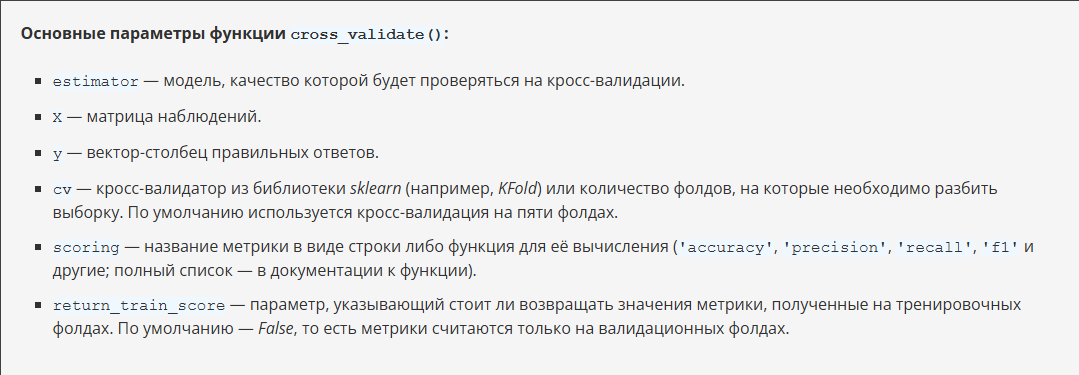

Функция возвращает словарь со следующими ключами:

- fit_time — время обучения модели на каждой итерации кросс-валидации;
- score_time — время вычисления метрик на каждой итерации кросс-валидации;
- test_score — значения метрик на валидационных фолдах;
- train_score — значения метрик на тренировочных фолдах.

**Итоговый код** с использованием функции cross_validate() будет выглядеть следующим образом:

In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)

{'fit_time': array([0.02099919, 0.01900244, 0.01800013, 0.01800013, 0.01753926]),
 'score_time': array([0.00099993, 0.00099993, 0.00099945, 0.00199986, 0.00100541]),
 'test_score': array([0.79573171, 0.70534351, 0.73587786, 0.72824427, 0.73282443]),
 'train_score': array([0.80343511, 0.81686379, 0.80274704, 0.82678367, 0.81571919])}

В массивах, хранящихся по ключам train_score и test_score, содержится по пять значений метрики accuracy, полученных на тренировочных и валидационных фолдах соответственно на каждой итерации кросс-валидации. Давайте рассчитаем среднее и сравним его с результатом, полученным ранее:

In [19]:
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.81
## Valid k-fold mean accuracy: 0.74

Train k-fold mean accuracy: 0.81
Valid k-fold mean accuracy: 0.74


Мы получили тот же результат, что и ранее. Согласитесь, функция cross_validate() значительно облегчает работу с кросс-валидацией.

### Задание 2.5

Производится *k-fold*-валидация на 10 фолдах. Размер выборки, поданной на кросс-валидацию, — (120, 8). Сколько раз будет обучаться модель?

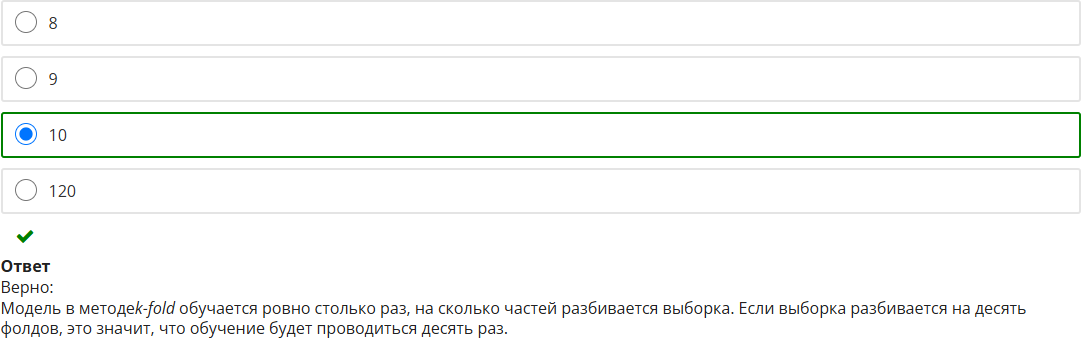

### Задание 2.6

В чём состоит преимущество *k-fold*-разбиения перед обычной *hold-out*-проверкой?

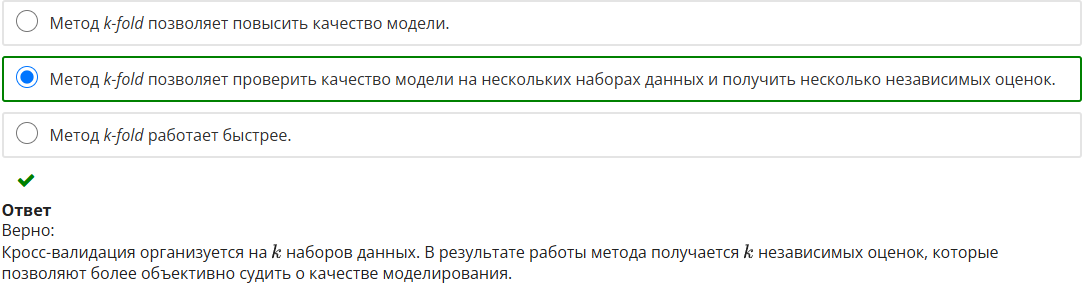

### Задание 2.7

В вашей выборке 500 примеров данных и 5 признаков для каждого примера. Вы используете *k-fold*-разбиение на 10 фолдов. Сколько примеров будут обозначены как тренировочные на каждой итерации кросс-валидации?

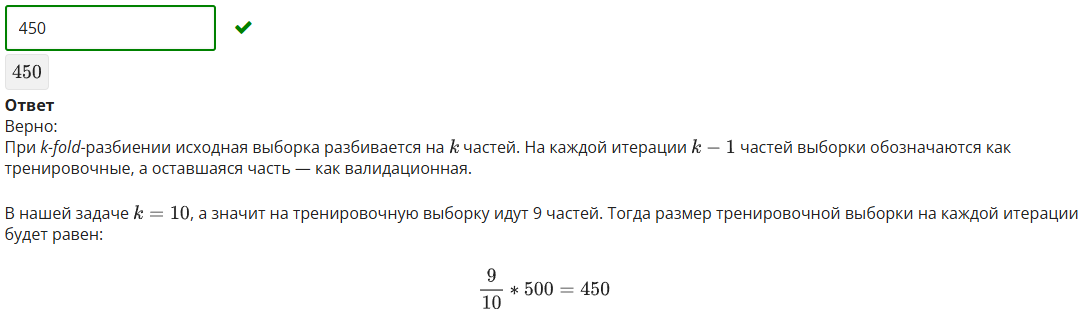

### Задание 2.8

Какой параметр класса *KFold* из библиотеки sklearn отвечает за количество фолдов, на которые будет разбита исходная выборка?

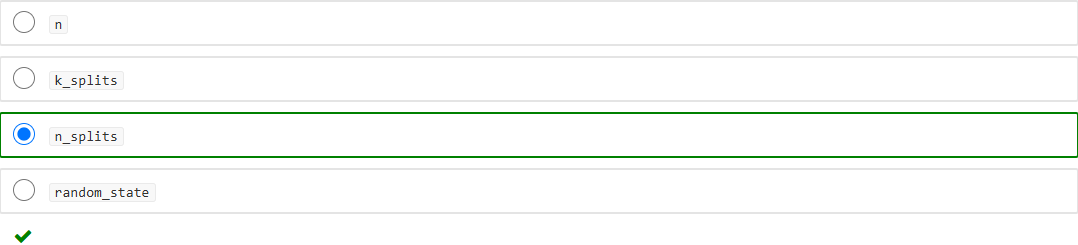

## LEAVE-ONE-OUT

> Метод **leave-one-out (отложенный пример)**, или **поэлементная кросс-валидация** — это частный случай кросс-валидации (*k-fold*), когда размер ***k*** равняется размеру всей выборки ****k=n***, где ***n*** — количество примеров (строк в таблице).

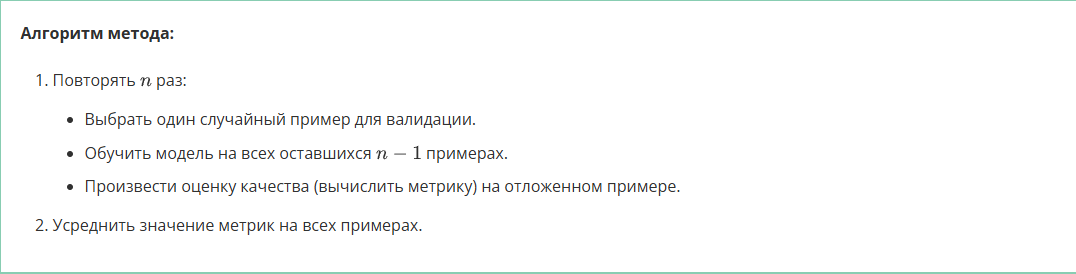

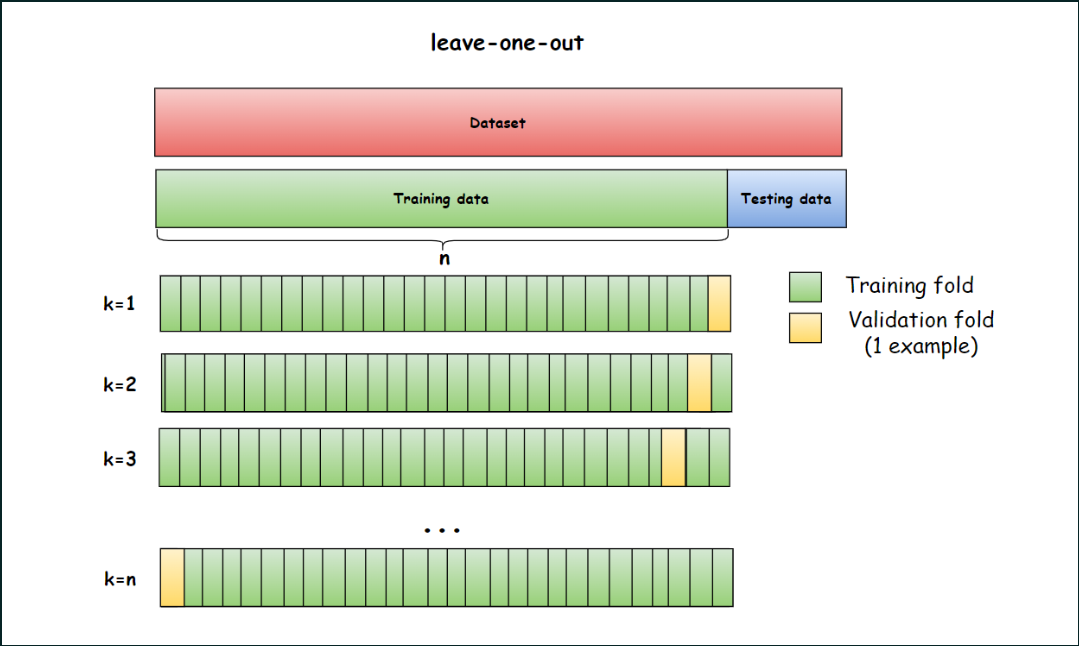

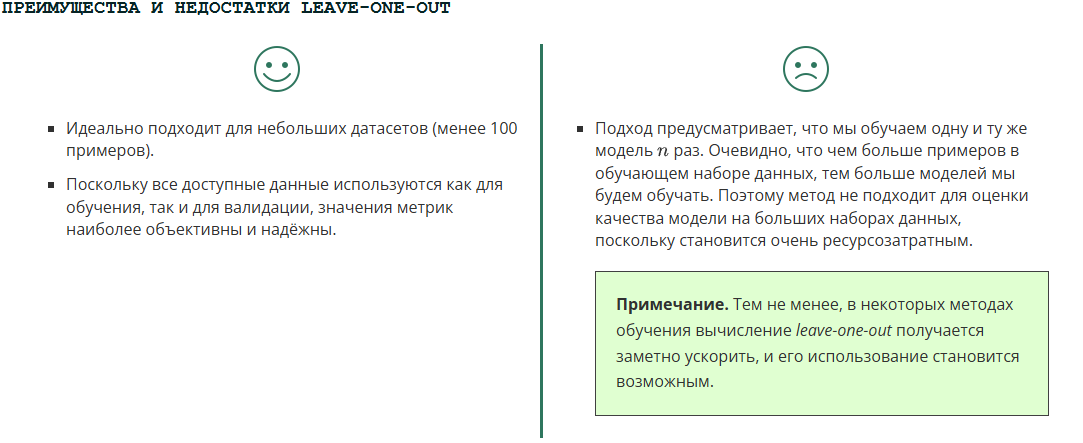

### Реализация метода в sklearn

В библиотеке sklearn метод leave-one-out реализован в классе [LeaveOneOut.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) Параметров инициализации у данного класса нет.

Работа с кросс-валидатором полностью идентична работе с *KFold*, который мы рассматривали ранее (цикл для организации кросс-валидации вручную будет выглядеть аналогично).

Объект класса *LeaveOneOut* также можно передать в функцию cross_validate() для получения метрик на каждом из примеров. В случае с метрикой accuracy список будет состоять из 0 и 1 (0 — модель не угадала класс на отложенном примере, 1 — модель угадала класс на отложенном примере).

Так как датасет у нас довольно большой (более трёх тысяч образцов воды), алгоритм кросс-валидации leave-one-out будет выполняться очень долго. Для экономии времени выполнения кода будем использовать первые 500 наблюдений из исходной таблицы.

> **Примечание.** Значение метрики будет рассчитано не для всего набора данных, а только для его части. Если вы захотите рассчитать метрику на всём наборе данных, вместо среза передавайте в функцию таблицу X и столбец y целиком. Но имейте в виду, что код в таком случае может выполняться до нескольких минут.

**Итоговый код:**

In [18]:
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём кросс-валидатор LeaveOneOut
loo = model_selection.LeaveOneOut()
 
#Считаем метрики на кросс-валидации leave-one-out
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X.iloc[:500], #матрица наблюдений X
    y=y.iloc[:500], #вектор ответов y
    cv=loo, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
 
## Train k-fold mean accuracy: 0.95
## Valid k-fold mean accuracy: 0.90

Train k-fold mean accuracy: 0.95
Valid k-fold mean accuracy: 0.90


> **Примечание.** Метод *leave-one-out* можно реализовать и без использования специального класса — достаточно просто указать параметр n_split=n в инициализаторе KFold, где n — количество строк в таблице.

### Задание 2.9

Что такое *leave-one-out*-разбиение?

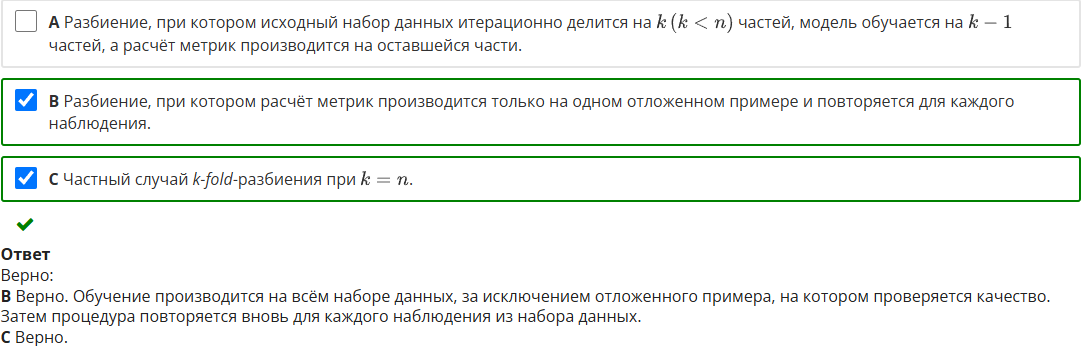

### Задание 2.10

Производится *leave-one-out*-валидация. Размер выборки, поданной на кросс-валидацию, — (120, 8). Сколько раз будет обучаться модель?

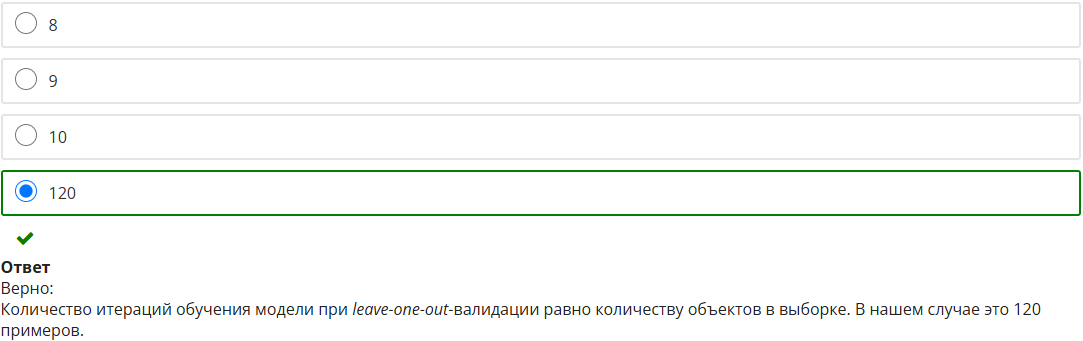

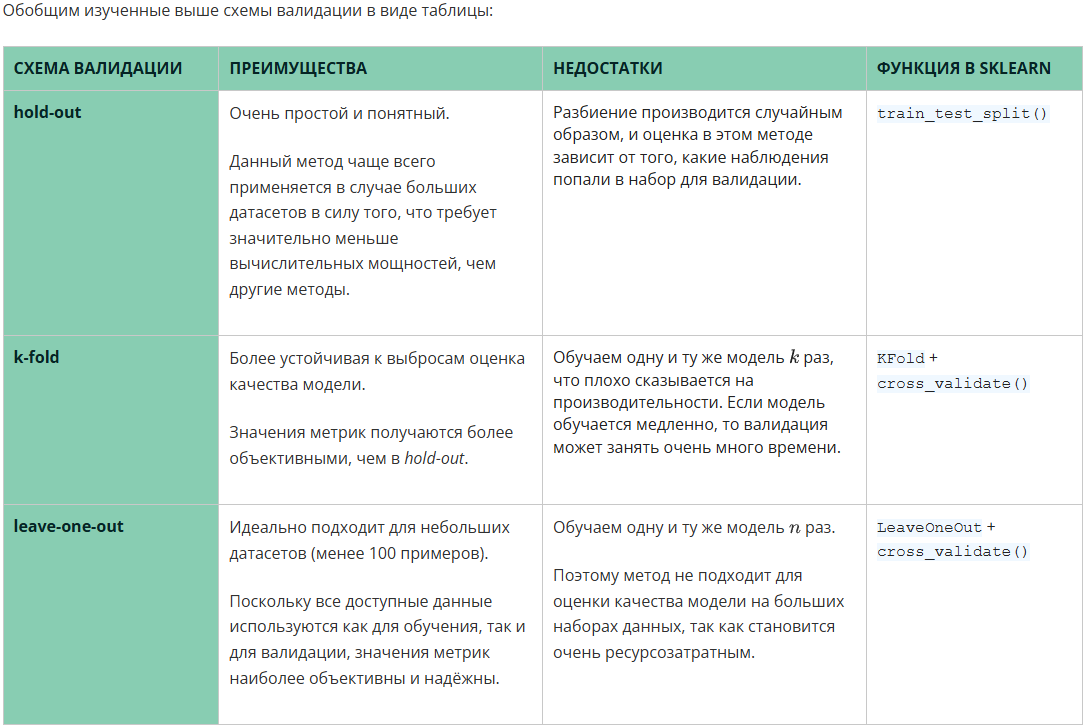